In [ ]:
#use an appropriate version of python (3.9.13 is what I used), as that is geared exclusively for this package now and doesn't have numpy

#pip install SquidstatPyLibrary-1.9.1.8-py3-none-win_amd64.whl

In [21]:
%gui qt

import sys
import struct
import time
import pandas as pd
from PySide6.QtWidgets import QApplication
from PySide6.QtCore import QEventLoop
from SquidstatPyLibrary import AisDeviceTracker
from SquidstatPyLibrary import AisCompRange
from SquidstatPyLibrary import AisDCData
from SquidstatPyLibrary import AisExperimentNode
from SquidstatPyLibrary import AisErrorCode
from SquidstatPyLibrary import AisExperiment, AisDCPotentialSweepElement
import numpy as np


from SquidstatPyLibrary import AisConstantPotElement
from SquidstatPyLibrary import AisCyclicVoltammetryElement
from SquidstatPyLibrary import AisConstantCurrentElement
from SquidstatPyLibrary import (
    AisDeviceTracker, AisCompRange, AisDCData, AisACData, AisExperimentNode,
    AisErrorCode, AisExperiment, AisInstrumentHandler, AisConstantCurrentElement, AisCyclicVoltammetryElement, AisErrorCode, AisExperiment
)
import matplotlib.pyplot as plt

app = QApplication.instance() or QApplication(sys.argv)
tracker = AisDeviceTracker.Instance()
tracker.connectToDeviceOnComPort("COM7")
#check COM port in device manager

In [22]:
device = 'Prime2645'

In [23]:
def record_cv(deviceName, low, high, end, start=0, step=0.01, sampling_interval=0.01, repeat=3):
    
    #this code records a cylic voltammogram of your sample. It accepts the device name, the lower V end, the upper V end, the end V, the start V (default set at 0), the step size in V/sec, sampling interval in s and repeats (default at 3)
    #it is advisable to save all the CV traces separately to make it easier to plot them
    
    print(f'Expected experiment time = {np.round((repeat * (abs(high - start) + abs(low - high) + abs(end - low))/step))} s')
    
    print(f"Device is Connected: {deviceName}")
    
    handler = tracker.getInstrumentHandler(deviceName)

    # Disconnect previous signal connections to avoid duplicates
    for signal in ['activeDCDataReady', 'experimentNewElementStarting', 'experimentStopped']:
        try:
            getattr(handler, signal).disconnect()
        except Exception:
            pass

    # List to store data records
    data_records = []

    # Connect signals to collect data
    handler.activeDCDataReady.connect(
        lambda channel, data: data_records.append({
            'timestamp': round(data.timestamp, 3),
            'working_electrode_voltage': round(data.workingElectrodeVoltage, 9),
            'counter_electrode_voltage': round(data.counterElectrodeVoltage, 9),
            'current': round(data.current, 9)
        })
    )

    handler.experimentNewElementStarting.connect(
        lambda channel, data: print(f"New Node beginning: {data.stepName}, "
                                    f"step number: {data.stepNumber}, step sub: {data.substepNumber}")
    )

    # Create a local event loop to wait for experiment completion
    loop = QEventLoop()
    handler.experimentStopped.connect(lambda channel: loop.quit())
    handler.experimentStopped.connect(lambda channel: print(f"Experiment Completed: {channel}"))

    # Set up the cyclic voltammetry experiment
    experiment = AisExperiment()
    cyclic = AisCyclicVoltammetryElement(start, low, high, end, step, sampling_interval)

    subExperiment = AisExperiment()
    success = subExperiment.appendElement(cyclic)
    success &= experiment.appendSubExperiment(subExperiment, repeat)

    error = handler.uploadExperimentToChannel(0, experiment)
    if error.value() != AisErrorCode.Success:
        print(f"Error uploading experiment: {error.message()}")
        return None

    error = handler.startUploadedExperiment(0)
    if error.value() != AisErrorCode.Success:
        print(f"Error starting experiment: {error.message()}")
        return None

    # Wait until the experiment stops
    loop.exec()

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data_records)
    return df

In [24]:
cv1 = record_cv(device, start= -0.25, low=-0.25, high=0.25, end=0.25, step=0.1, sampling_interval=0.05, repeat=1)
cv2 = record_cv(device, start= -0.2, low=-0.2, high=0.2, end=0.2, step=0.1, sampling_interval=0.05, repeat=1)
cv3 = record_cv(device, start=-0.15, low=-0.15, high=0.15, end=0.15, step=0.1, sampling_interval=0.05, repeat=1)

Expected experiment time = 15.0 s
Device is Connected: Prime2645
New Node beginning: Cyclic Voltammetry, step number: 1, step sub: 0
Experiment Completed: 0
Expected experiment time = 12.0 s
Device is Connected: Prime2645
New Node beginning: Cyclic Voltammetry, step number: 1, step sub: 0
Experiment Completed: 0
Expected experiment time = 9.0 s
Device is Connected: Prime2645
New Node beginning: Cyclic Voltammetry, step number: 1, step sub: 0
Experiment Completed: 0


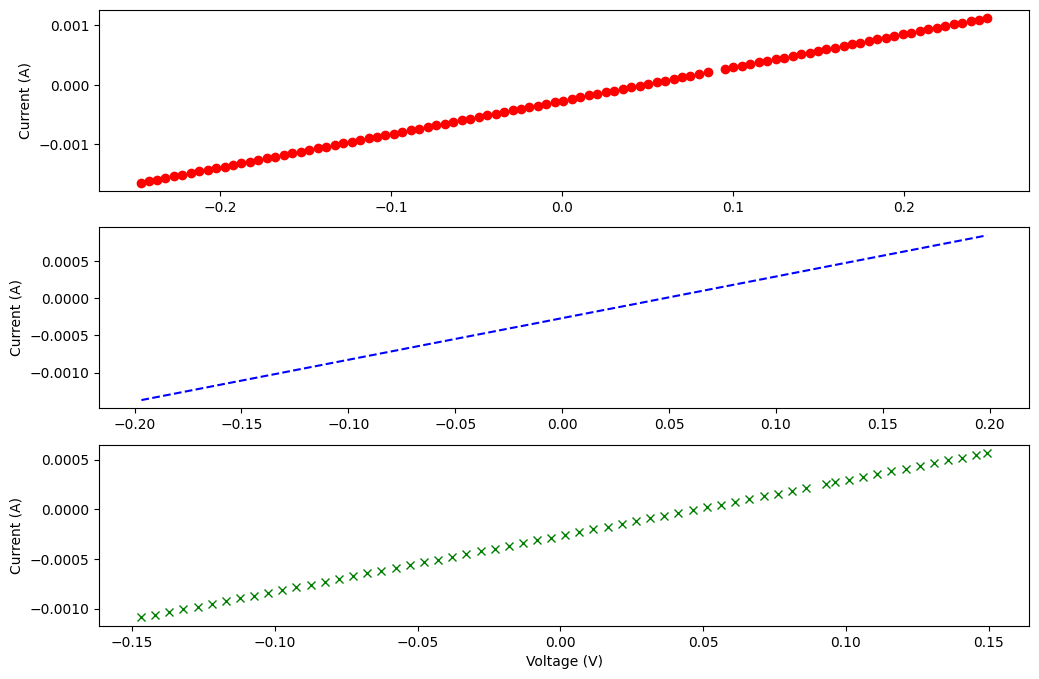

In [ ]:
plt.figure(figsize= (12, 8))
plt.subplot(311)
plt.plot(cv1['working_electrode_voltage'], cv1['current'], 'ro')
plt.ylabel('Current (A)')

plt.subplot(312)
plt.plot(cv2['working_electrode_voltage'], cv2['current'], 'b--')
plt.ylabel('Current (A)')

plt.subplot(313)
plt.plot(cv3['working_electrode_voltage'], cv3['current'], 'gx')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')

plt.show()

#testing

In [26]:
def cp_mode(deviceName, current=0.01, duration=10, repeat=1, sampling_interval=1):
    
    #this code will run a constant current experiment at a set current in A (default's set at 10 mA) for a duration (in s) for a total time duration (in s). The measurement can be repeated (default is 1) and the instrument measures the V response every sampling_interval s.
    
    print(f'Expected experiment time = {duration * repeat} s')
    
    print("Device is Connected: %s" % deviceName)
    handler = tracker.getInstrumentHandler("Prime2645")
    
    # Clear previous signal connections to avoid duplicates
    for signal in ['activeDCDataReady', 'experimentNewElementStarting', 'experimentStopped']:
        try:
            getattr(handler, signal).disconnect()
        except Exception:
            pass

    # List to store records
    records = []
    
    # Collect data without printing each time
    handler.activeDCDataReady.connect(
        lambda channel, data: records.append({
            'timestamp': round(data.timestamp, 3),
            'working_electrode_voltage': round(data.workingElectrodeVoltage, 9),
            'counter_electrode_voltage': round(data.counterElectrodeVoltage, 9),
            'current': round(data.current, 9)
        })
    )
    
    # (Optional) Print new node information
    handler.experimentNewElementStarting.connect(
        lambda channel, data: print(f"New Node beginning: {data.stepName}, step number: {data.stepNumber}, step sub: {data.substepNumber}")
    )
    
    # Create a local event loop that will wait until the experiment stops
    loop = QEventLoop()
    
    def on_experiment_stopped(channel):
        print(f"Experiment Completed: {channel}")
        loop.quit()
    
    handler.experimentStopped.connect(on_experiment_stopped)
    
    # Set up experiment elements
    experiment = AisExperiment()
    ccElement = AisConstantCurrentElement(current, sampling_interval, duration)
    
    subExperiment = AisExperiment()
    success = subExperiment.appendElement(ccElement)
    success &= experiment.appendSubExperiment(subExperiment, repeat)
    
    error = handler.uploadExperimentToChannel(0, experiment)
    if error.value() != AisErrorCode.Success:
        print("Error uploading experiment: %s" % error.message())
        return None
    
    error = handler.startUploadedExperiment(0)
    if error.value() != AisErrorCode.Success:
        print("Error starting experiment: %s" % error.message())
        return None
    
    # Block until the experiment completes
    loop.exec()
    
    # Convert collected records into a DataFrame and return it
    df = pd.DataFrame(records)
    return df

In [ ]:
cp = cp_mode("Prime2645", current=0.01, duration=10, repeat=2, sampling_interval=1)
cp['R'] = (cp.working_electrode_voltage) / (cp.current)
cp

#testing

Expected experiment time = 20 s
Device is Connected: Prime2645
New Node beginning: Constant Current, step number: 1, step sub: 1
New Node beginning: Constant Current, step number: 1, step sub: 2
Experiment Completed: 0


,timestamp,working_electrode_voltage,counter_electrode_voltage,current,R
0,1.000,0.998070,0.000121,0.009992,99.889229
1,2.000,0.998210,0.000100,0.009993,99.887285
2,3.000,0.998243,0.000088,0.009994,99.886848
3,4.001,0.998261,0.000146,0.009994,99.886139
4,5.001,0.998285,0.000155,0.009994,99.886826
5,6.001,0.998291,0.000131,0.009994,99.886772
6,7.001,0.998308,0.000125,0.009994,99.887752
7,8.001,0.998323,0.000132,0.009994,99.889159
8,9.001,0.998308,0.000146,0.009994,99.887175
9,10.000,0.998324,0.000133,0.009994,99.887777


In [28]:
def ca_mode(deviceName, set_V=0.01, duration=10, repeat=1, sampling_interval=1):
    
    #this code will run a constant voltage experiment at a set voltage in V (default's set at 10 mV) for a duration (in s) for a total time duration (in s). The measurement can be repeated (default is 1) and the instrument measures the current response every sampling_interval s.
    
    print(f'Expected experiment time = {duration * repeat} s')
    
    print("Device is Connected: %s" % deviceName)
    handler = tracker.getInstrumentHandler("Prime2645")
    
    # Clear previous signal connections to avoid duplicates
    for signal in ['activeDCDataReady', 'experimentNewElementStarting', 'experimentStopped']:
        try:
            getattr(handler, signal).disconnect()
        except Exception:
            pass

    # List to store records
    records = []
    
    # Collect data without printing each time
    handler.activeDCDataReady.connect(
        lambda channel, data: records.append({
            'timestamp': round(data.timestamp, 3),
            'working_electrode_voltage': round(data.workingElectrodeVoltage, 9),
            'counter_electrode_voltage': round(data.counterElectrodeVoltage, 9),
            'current': round(data.current, 9)
        })
    )
    
    # (Optional) Print new node information
    handler.experimentNewElementStarting.connect(
        lambda channel, data: print(f"New Node beginning: {data.stepName}, step number: {data.stepNumber}, step sub: {data.substepNumber}")
    )
    
    # Create a local event loop that will wait until the experiment stops
    loop = QEventLoop()
    
    def on_experiment_stopped(channel):
        print(f"Experiment Completed: {channel}")
        loop.quit()
    
    handler.experimentStopped.connect(on_experiment_stopped)
    
    # Set up experiment elements
    experiment = AisExperiment()
    # define constant potential experiment at 0.5 V with a sampling interval of 1 s and a duration of 10 s
    cvElement = AisConstantPotElement(set_V, sampling_interval, duration)
    
    subExperiment = AisExperiment()
    success = subExperiment.appendElement(cvElement)
    success &= experiment.appendSubExperiment(subExperiment, repeat)
    
    error = handler.uploadExperimentToChannel(0, experiment)
    if error.value() != AisErrorCode.Success:
        print("Error uploading experiment: %s" % error.message())
        return None
    
    error = handler.startUploadedExperiment(0)
    if error.value() != AisErrorCode.Success:
        print("Error starting experiment: %s" % error.message())
        return None
    
    # Block until the experiment completes
    loop.exec()
    
    # Convert collected records into a DataFrame and return it
    df = pd.DataFrame(records)
    return df

In [29]:
ca = ca_mode(device, set_V=0.01, duration=10, repeat=2, sampling_interval=1)
ca

#testing

Expected experiment time = 20 s
Device is Connected: Prime2645
New Node beginning: Constant Potential, step number: 1, step sub: 1
New Node beginning: Constant Potential, step number: 1, step sub: 2
Experiment Completed: 0


,timestamp,working_electrode_voltage,counter_electrode_voltage,current
0,1.000,0.015541,0.000051,-0.000180
1,2.000,0.011079,0.000052,-0.000205
2,3.000,0.010887,0.000048,-0.000207
3,4.001,0.010799,0.000026,-0.000207
4,5.001,0.010743,0.000039,-0.000208
5,6.001,0.010699,0.000038,-0.000208
6,7.001,0.010666,0.000056,-0.000208
7,8.001,0.010632,0.000055,-0.000208
8,9.001,0.010629,0.000035,-0.000208
9,10.000,0.010626,0.000072,-0.000208


In [30]:
def dc_sweep(deviceName, end, scan_rate, start=0, sampling_interval=1, repeat = 1):
    
    #this code sweeps the voltage between start (default set at 0 V) to the end voltage at a set scan_rate (in V/sec). It samples the current response every 'sampling_interval' seconds and this measurement can be repeated (default is set at 1)
    
    print(f'Expected experiment time = {(end - start)/scan_rate} s')
    
    print("Device is Connected: %s" % deviceName)
    handler = tracker.getInstrumentHandler("Prime2645")
    
    # Clear previous signal connections to avoid duplicates
    for signal in ['activeDCDataReady', 'experimentNewElementStarting', 'experimentStopped']:
        try:
            getattr(handler, signal).disconnect()
        except Exception:
            pass

    # List to store records
    records = []
    
    # Collect data without printing each time
    handler.activeDCDataReady.connect(
        lambda channel, data: records.append({
            'timestamp': round(data.timestamp, 3),
            'working_electrode_voltage': round(data.workingElectrodeVoltage, 9),
            'counter_electrode_voltage': round(data.counterElectrodeVoltage, 9),
            'current': round(data.current, 9)
        })
    )
    
    # (Optional) Print new node information
    handler.experimentNewElementStarting.connect(
        lambda channel, data: print(f"New Node beginning: {data.stepName}, step number: {data.stepNumber}, step sub: {data.substepNumber}")
    )
    
    # Create a local event loop that will wait until the experiment stops
    loop = QEventLoop()
    
    def on_experiment_stopped(channel):
        print(f"Experiment Completed: {channel}")
        loop.quit()
    
    handler.experimentStopped.connect(on_experiment_stopped)
    
    # Set up experiment elements
    experiment = AisExperiment()
    # define constant potential experiment at 0.5 V with a sampling interval of 1 s and a duration of 10 s
    dc = AisDCPotentialSweepElement(start, end, scan_rate, sampling_interval)
    
    subExperiment = AisExperiment()
    success = subExperiment.appendElement(dc)
    success &= experiment.appendSubExperiment(subExperiment, repeat)
    
    error = handler.uploadExperimentToChannel(0, experiment)
    if error.value() != AisErrorCode.Success:
        print("Error uploading experiment: %s" % error.message())
        return None
    
    error = handler.startUploadedExperiment(0)
    if error.value() != AisErrorCode.Success:
        print("Error starting experiment: %s" % error.message())
        return None
    
    # Block until the experiment completes
    loop.exec()
    
    # Convert collected records into a DataFrame and return it
    df = pd.DataFrame(records)
    return df

In [31]:
dc = dc_sweep(device, start = 0, end = 0.5, scan_rate = 0.025, sampling_interval = 1)
dc['R'] = (dc.working_electrode_voltage)/(dc.current)
dc

#testing

Expected experiment time = 20.0 s
Device is Connected: Prime2645
New Node beginning: Potential Linear Sweep, step number: 1, step sub: 1
Experiment Completed: 0


,timestamp,working_electrode_voltage,counter_electrode_voltage,current,R
0,1.102,0.012198,0.000082,-0.000200,-61.088805
1,2.106,0.037183,0.000079,-0.000060,-624.848273
2,3.109,0.062386,0.000130,0.000082,762.460231
3,4.112,0.096241,0.000158,0.000272,353.901730
4,5.116,0.112673,0.000153,0.000364,309.803361
5,6.119,0.137838,0.000117,0.000505,273.090727
6,7.122,0.162957,0.000129,0.000646,252.319216
7,8.126,0.188060,0.000136,0.000787,239.077931
8,9.129,0.213182,0.000150,0.000928,229.813207
9,10.132,0.238283,0.000200,0.001069,222.985781
